In [1]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sys.path.append('../../src')
import cb_utils
import ds_matching

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

### DS Patient Hours Recomendation Models

#### Plan is to train boosted tree model with both sfere and claims features
- Use last 30d as test set
- also train two versions of quantile model on best features
    1. with current hrs
    2. without current hrs

In [42]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_rec_hrs_modelling_w_claims_20230110.csv', low_memory=False)
print(f'{df.shape[0]} samples')
df.head()

15710 samples


,sfere_id,patient_id,payer_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg,group_id_ft,glaucoma_ddos_ft,cataract_ddos_ft,behavioral_health_ddos_ft,osteoporosis_ddos_ft,hiv_ddos_ft,transplants_ddos_ft,obesity_ddos_ft,cancer_ddos_ft,hip_pelvic_fracture_ddos_ft,sclerosis_ddos_ft,rheumatoid_arthritis_ddos_ft,ckd_ddos_ft,hyperlipidemia_ddos_ft,diabetes_ddos_ft,hypothyroidism_ddos_ft,pressure_ulcer_ddos_ft,weight_loss_ddos_ft,heart_ddos_ft,peptic_ulcer_ddos_ft,anemia_ddos_ft,substance_abuse_ddos_ft,liver_ddos_ft,disabled_ddos_ft,fall_ddos_ft,stroke_ddos_ft,paralysis_ddos_ft,hypertension_ddos_ft,peripheral_vascular_ddos_ft,coagulation_ddos_ft,fluid_ddos_ft,benign_prostatic_hyperplasia_ddos_ft,tbi_ddos_ft,neurocognitive_ddos_ft,pulmonary_ddos_ft,glaucoma_tc_ft,cataract_tc_ft,behavioral_health_tc_ft,osteoporosis_tc_ft,hiv_tc_ft,transplants_tc_ft,obesity_tc_ft,cancer_tc_ft,hip_pelvic_fracture_tc_ft,sclerosis_tc_ft,rheumatoid_arthritis_tc_ft,ckd_tc_ft,hyperlipidemia_tc_ft,diabetes_tc_ft,hypothyroidism_tc_ft,pressure_ulcer_tc_ft,weight_loss_tc_ft,heart_tc_ft,peptic_ulcer_tc_ft,anemia_tc_ft,substance_abuse_tc_ft,liver_tc_ft,disabled_tc_ft,fall_tc_ft,stroke_tc_ft,paralysis_tc_ft,hypertension_tc_ft,peripheral_vascular_tc_ft,coagulation_tc_ft,fluid_tc_ft,benign_prostatic_hyperplasia_tc_ft,tbi_tc_ft,neurocognitive_tc_ft,pulmonary_tc_ft,submitted_last_30d
0,14799,14020,8,93,0,0,0,0,2,0,2.0,0,NaN,1,0.0,0.0,0,0,0,1,0.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,28,273,2,76,2,3,2,2,2,0,2.0,2,NaN,1,NaN,0.0,0,0,1,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0,18.0,15.0,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,382.84,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,348.91,0.00,0.00,0.00,0.0,199.89,0.0,64.27,0.0,0.0,0.0,264.16,348.91,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,125.40,False
2,16896,13517,8,88,2,2,2,2,2,0,2.0,2,NaN,1,2.0,2.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,83.06,0.0,0.0,0.00,0.0,0.0,0.0,83.06,0.00,0.00,0.00,0.00,0.00,0.0,270.11,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,False
3,34342,2911,2,78,1,1,1,2,2,1,2.0,1,NaN,0,NaN,NaN,0,0,2,2,1.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0,15.0,10.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,6147,1553,2,69,2,2,2,3,2,2,2.0,2,NaN,1,NaN,0.0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,13.0,13.0,-1,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,171.0,8.0,29.0,6.0,

In [43]:
df = df.loc[df.payer_id_ft != 5]

In [44]:
# filter out 0 recs
df = df.loc[df.reporting_rec_hrs_tg > 0]
print(f'{df.shape[0]} samples above 0')

12080 samples above 0


### Features

In [45]:
potential_features = [f for f in df.columns if f.endswith('_ft')]
potential_features 

['payer_id_ft',
 'age_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'reporting_current_hrs_ft',
 'group_id_ft',
 'glaucoma_ddos_ft',
 'cataract_ddos_ft',
 'behavioral_health_ddos_ft',
 'osteoporosis_ddos_ft',
 'hiv_ddos_ft',
 'transplant

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

In [47]:
categorical_features = [
 'payer_id_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft'
    # , 'group_id_ft'
]

cont_features = [
 # 'reporting_current_hrs_ft',
 'age_ft',
    
 'glaucoma_ddos_ft',
 'cataract_ddos_ft',
 'behavioral_health_ddos_ft',
 'osteoporosis_ddos_ft',
 'hiv_ddos_ft',
 'transplants_ddos_ft',
 'obesity_ddos_ft',
 'cancer_ddos_ft',
 'hip_pelvic_fracture_ddos_ft',
 'sclerosis_ddos_ft',
 'rheumatoid_arthritis_ddos_ft',
 'ckd_ddos_ft',
 'hyperlipidemia_ddos_ft',
 'diabetes_ddos_ft',
 'hypothyroidism_ddos_ft',
 'pressure_ulcer_ddos_ft',
 'weight_loss_ddos_ft',
 'heart_ddos_ft',
 'peptic_ulcer_ddos_ft',
 'anemia_ddos_ft',
 'substance_abuse_ddos_ft',
 'liver_ddos_ft',
 'disabled_ddos_ft',
 'fall_ddos_ft',
 'stroke_ddos_ft',
 'paralysis_ddos_ft',
 'hypertension_ddos_ft',
 'peripheral_vascular_ddos_ft',
 'coagulation_ddos_ft',
 'fluid_ddos_ft',
 'benign_prostatic_hyperplasia_ddos_ft',
 'tbi_ddos_ft',
 'neurocognitive_ddos_ft',
 'pulmonary_ddos_ft',
    
 #     'glaucoma_tc_ft',
 # 'cataract_tc_ft',
 # 'behavioral_health_tc_ft',
 # 'osteoporosis_tc_ft',
 # 'hiv_tc_ft',
 # 'transplants_tc_ft',
 # 'obesity_tc_ft',
 # 'cancer_tc_ft',
 # 'hip_pelvic_fracture_tc_ft',
 # 'sclerosis_tc_ft',
 # 'rheumatoid_arthritis_tc_ft',
 # 'ckd_tc_ft',
 # 'hyperlipidemia_tc_ft',
 # 'diabetes_tc_ft',
 # 'hypothyroidism_tc_ft',
 # 'pressure_ulcer_tc_ft',
 # 'weight_loss_tc_ft',
 # 'heart_tc_ft',
 # 'peptic_ulcer_tc_ft',
 # 'anemia_tc_ft',
 # 'substance_abuse_tc_ft',
 # 'liver_tc_ft',
 # 'disabled_tc_ft',
 # 'fall_tc_ft',
 # 'stroke_tc_ft',
 # 'paralysis_tc_ft',
 # 'hypertension_tc_ft',
 # 'peripheral_vascular_tc_ft',
 # 'coagulation_tc_ft',
 # 'fluid_tc_ft',
 # 'benign_prostatic_hyperplasia_tc_ft',
 # 'tbi_tc_ft',
 # 'neurocognitive_tc_ft',
 # 'pulmonary_tc_ft'
]
 

features = categorical_features + cont_features
target = 'reporting_rec_hrs_tg'
categorical_feature_indexes = [i for i in range(len(categorical_features))]

In [48]:
df[categorical_features].head()

,payer_id_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft
0,8,0,0,0,0,2,0,2.0,0,NaN,1,0.0,0.0,0,0,0,1,0.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0
1,2,2,3,2,2,2,0,2.0,2,NaN,1,NaN,0.0,0,0,1,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0
3,2,1,1,1,2,2,1,2.0,1,NaN,0,NaN,NaN,0,0,2,2,1.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0
4,2,2,2,2,3,2,2,2.0,2,NaN,1,NaN,0.0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0
5,2,2,2,2,2,2,0,2.0,2,NaN,1,NaN,2.0,0,0,1,1,NaN,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0


In [49]:
# make sure data always exists
missing_cat = df[categorical_features].count() / df.shape[0]

In [50]:
# features present in < 50% samples
low_freq_feats = [x for x in missing_cat.items() if x[1] <= .5]
low_freq_feats 

[('turn_change_position_ft', 0.1403973509933775),
 ('cleaning_ft', 0.08178807947019867),
 ('laundry_ft', 0.27591059602649004),
 ('change_bed_ft', 0.06274834437086092),
 ('clean_kitchen_ft', 0.06274834437086092),
 ('clean_home_ft', 0.06274834437086092),
 ('medical_appointments_ft', 0.1403973509933775),
 ('work_school_socialize_ft', 0.06274834437086092)]

In [51]:
# make sure data always exists
missing_cont = df[cont_features].count() / df.shape[0]
missing_cont

age_ft                                  1.000000
glaucoma_ddos_ft                        0.870033
cataract_ddos_ft                        0.870033
behavioral_health_ddos_ft               0.870033
osteoporosis_ddos_ft                    0.870033
hiv_ddos_ft                             0.870033
transplants_ddos_ft                     0.870033
obesity_ddos_ft                         0.870033
cancer_ddos_ft                          0.870033
hip_pelvic_fracture_ddos_ft             0.870033
sclerosis_ddos_ft                       0.870033
rheumatoid_arthritis_ddos_ft            0.870033
ckd_ddos_ft                             0.870033
hyperlipidemia_ddos_ft                  0.870033
diabetes_ddos_ft                        0.870033
hypothyroidism_ddos_ft                  0.870033
pressure_ulcer_ddos_ft                  0.870033
weight_loss_ddos_ft                     0.870033
heart_ddos_ft                           0.870033
peptic_ulcer_ddos_ft                    0.870033
anemia_ddos_ft      

In [52]:
len(features)

72

In [53]:
# Likely want to drop low frequency features in categorical vars
lf_feats = [lff[0] for lff in low_freq_feats]
features = [f for f in features if f not in lf_feats]

In [54]:
len(features)

64

In [55]:
len(categorical_features)

37

In [56]:
# need to drop the low_freq categorical feature indexes
categorical_feature_indexes = categorical_feature_indexes[:-len(low_freq_feats)]

In [57]:
len(categorical_feature_indexes)

29

### Train Validation Test Split

In [58]:
# test set: all sferes submitted in last 30d plus any other sferes for thos patients
test_df = df.loc[df.submitted_last_30d]
test_df_patient_ids = test_df.patient_id.unique()
test_df = df.loc[df.patient_id.isin(test_df_patient_ids)]
print(f'{test_df.shape[0]} test samples, for {test_df_patient_ids.shape[0]} unique patients')

1938 test samples, for 1625 unique patients


In [59]:
training_df = df.loc[~df.patient_id.isin(test_df_patient_ids)]
training_df_patient_ids = training_df.patient_id.unique()
print(f'{training_df.shape[0]} training samples, for {training_df_patient_ids.shape[0]} unique patients')

10142 training samples, for 8842 unique patients


In [60]:
val_pct = 0.15
val_df_patient_ids = random.sample(list(training_df_patient_ids), int(training_df.shape[0]*val_pct))
val_df = training_df.loc[training_df.patient_id.isin(val_df_patient_ids)]
val_df.shape[0]
print(f'{val_df.shape[0]} val samples, for {len(val_df_patient_ids)} unique patients')

1717 val samples, for 1521 unique patients


In [61]:
train_no_val_df = training_df.loc[~training_df.patient_id.isin(val_df_patient_ids)]
print(f'{train_no_val_df.shape[0]} train samples, for {train_no_val_df.patient_id.unique().shape[0]} unique patients')

8425 train samples, for 7321 unique patients


### All assessor model

In [62]:
x_train = train_no_val_df[features]
y_train = train_no_val_df[target]

x_val = val_df[features]
y_val = val_df[target]

In [63]:
aa_est = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                       max_iter=1000).fit(x_train, y_train)

In [64]:
aa_preds = aa_est.predict(x_val)

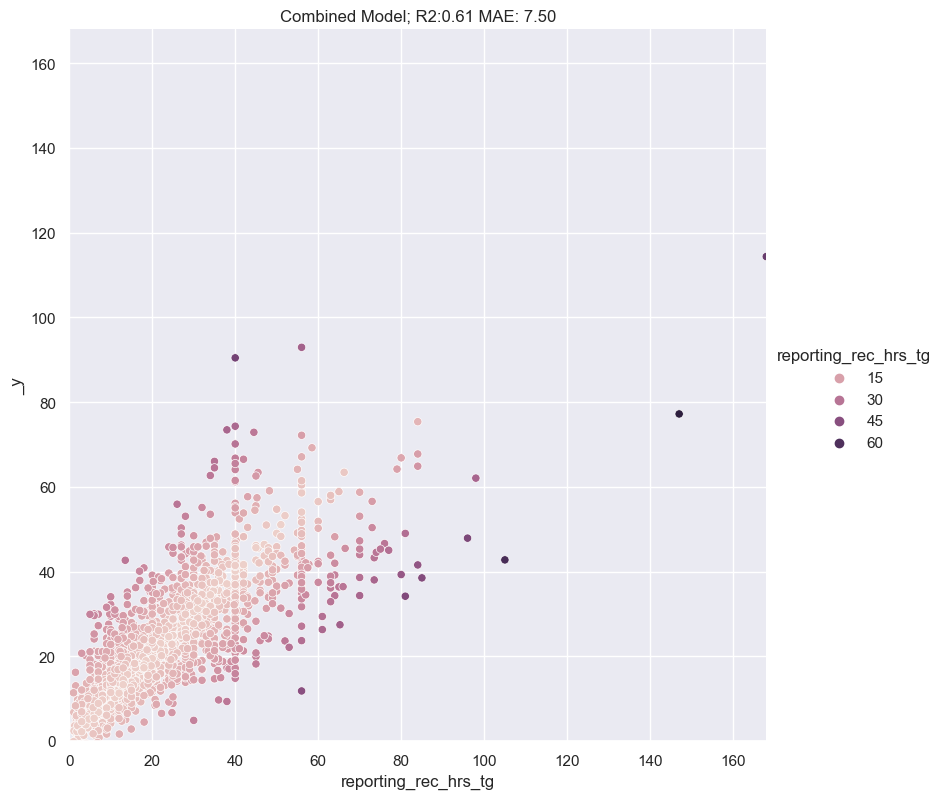

In [65]:
# preds vs rec
ax = sns.relplot(x=y_val, y=aa_preds, height=8, hue=np.abs(y_val - aa_preds))
ax.set(ylim=(0, 168))
ax.set(xlim=(0, 168))
ax.set(title=f'Combined Model; R2:{aa_est.score(x_val, y_val):.02f} MAE: {np.mean(np.abs(y_val - aa_preds)):.02f}');

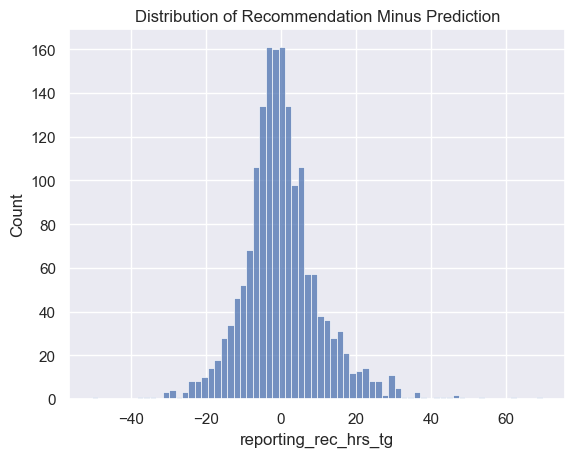

In [66]:
ax = sns.histplot(x=y_val - aa_preds)
ax.set(title=f'Distribution of Recommendation Minus Prediction');

In [67]:
from sklearn.inspection import permutation_importance

In [68]:
print('All assessor model features')
r = permutation_importance(aa_est, x_val, y_val,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

All assessor model features


In [69]:
best_features = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features.append(features[i])
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")
best_features

payer_id_ft 0.541  +/- 0.037
toileting_ft 0.058  +/- 0.006
transfer_bed_to_chair_ft 0.031  +/- 0.005
age_ft   0.028  +/- 0.005
meal_prep_ft 0.019  +/- 0.005
dressing_ft 0.019  +/- 0.004
bathing_ft 0.017  +/- 0.004
grooming_ft 0.016  +/- 0.004
medication_management_ft 0.012  +/- 0.004
transportation_ft 0.012  +/- 0.003
transfer_chair_to_standing_ft 0.010  +/- 0.004
hypertension_ddos_ft 0.010  +/- 0.004
has_dementia_ft 0.009  +/- 0.003
comprehension_ft 0.006  +/- 0.002
alert_oriented_day_time_ft 0.006  +/- 0.002
neurocognitive_ddos_ft 0.005  +/- 0.002
cataract_ddos_ft 0.003  +/- 0.001
finances_ft 0.003  +/- 0.001


['payer_id_ft',
 'toileting_ft',
 'transfer_bed_to_chair_ft',
 'age_ft',
 'meal_prep_ft',
 'dressing_ft',
 'bathing_ft',
 'grooming_ft',
 'medication_management_ft',
 'transportation_ft',
 'transfer_chair_to_standing_ft',
 'hypertension_ddos_ft',
 'has_dementia_ft',
 'comprehension_ft',
 'alert_oriented_day_time_ft',
 'neurocognitive_ddos_ft',
 'cataract_ddos_ft',
 'finances_ft']

### Try retraining on only the top features

In [70]:
b_categorical_features = [c for c in categorical_features if c in best_features]
b_cat_feat_indexes = [i for i in range(len(b_categorical_features))]
b_categorical_features, b_cat_feat_indexes

(['payer_id_ft',
  'transfer_bed_to_chair_ft',
  'transfer_chair_to_standing_ft',
  'dressing_ft',
  'bathing_ft',
  'grooming_ft',
  'toileting_ft',
  'meal_prep_ft',
  'medication_management_ft',
  'finances_ft',
  'transportation_ft',
  'comprehension_ft',
  'alert_oriented_day_time_ft',
  'has_dementia_ft'],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [71]:
b_cont_features = [c for c in cont_features if c in best_features]
b_cont_features

['age_ft',
 'cataract_ddos_ft',
 'hypertension_ddos_ft',
 'neurocognitive_ddos_ft']

In [72]:
b_features = b_categorical_features + b_cont_features
b_features

['payer_id_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'dressing_ft',
 'bathing_ft',
 'grooming_ft',
 'toileting_ft',
 'meal_prep_ft',
 'medication_management_ft',
 'finances_ft',
 'transportation_ft',
 'comprehension_ft',
 'alert_oriented_day_time_ft',
 'has_dementia_ft',
 'age_ft',
 'cataract_ddos_ft',
 'hypertension_ddos_ft',
 'neurocognitive_ddos_ft']

In [73]:
x_train = train_no_val_df[b_features]
y_train = train_no_val_df[target]

x_val = val_df[b_features]
y_val = val_df[target]

In [74]:
aa_est = HistGradientBoostingRegressor(categorical_features=b_cat_feat_indexes,
                                       max_iter=1000).fit(x_train, y_train)

In [75]:
aa_preds = aa_est.predict(x_val)

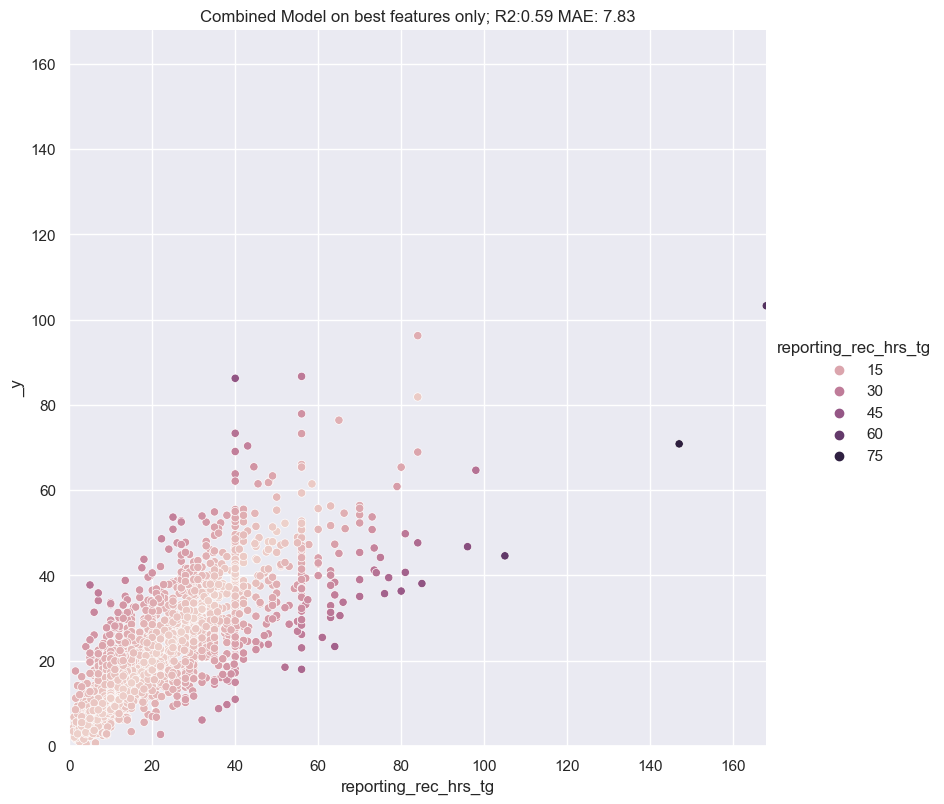

In [76]:
# preds vs rec
ax = sns.relplot(x=y_val, y=aa_preds, height=8, hue=np.abs(y_val - aa_preds))
ax.set(ylim=(0, 168))
ax.set(xlim=(0, 168))
ax.set(title=f'Combined Model on best features only; R2:{aa_est.score(x_val, y_val):.02f} MAE: {np.mean(np.abs(y_val - aa_preds)):.02f}');

#### Results 
Training on feature subset performed slightly better than previous.
Use that feature subset for quantile models

### Train quantile model 

In [36]:
# Set lower and upper quantile
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

lower_model = HistGradientBoostingRegressor(categorical_features=b_cat_feat_indexes,
                                            loss="quantile",
                                            quantile=LOWER_ALPHA
                                           ).fit(x_train, y_train)

upper_model = HistGradientBoostingRegressor(categorical_features=b_cat_feat_indexes,
                                            loss="quantile",
                                            quantile=UPPER_ALPHA
                                           ).fit(x_train, y_train)

In [37]:
l_preds = lower_model.predict(x_val)
h_preds = upper_model.predict(x_val)

In [38]:
q_results = []
for row in zip(y_val, l_preds, h_preds, aa_preds):
    q_results.append(row)
q_results_df = pd.DataFrame(q_results, columns=['actual', 'low', 'high', 'best']) 

In [39]:
q_results_df = q_results_df.assign(
    mae=np.abs(q_results_df.best - q_results_df.actual), 
    in_range=(q_results_df.actual >= q_results_df.low) & (q_results_df.actual <= q_results_df.high),
    out_of_range=np.where(q_results_df.actual > q_results_df.high, 'actual_higher', np.where(q_results_df.actual < q_results_df.low, 'actual_lower', 'in_range'))
)
q_results_df.head()

,actual,low,high,best,mae,in_range,out_of_range
0,35.00,13.937574,52.279019,30.060481,4.939519,True,in_range
1,8.45,1.788993,20.961320,8.132978,0.317022,True,in_range
2,24.00,11.387074,45.090786,28.723271,4.723271,True,in_range
3,30.00,13.754260,53.946702,31.044029,1.044029,True,in_range
4,2.03,2.515104,18.023675,9.594784,7.564784,False,actual_lower


In [40]:
q_melt = pd.melt(q_results_df, id_vars=['actual', 'mae', 'in_range', 'out_of_range'], value_vars=['low', 'high', 'best'])
q_melt.head()

,actual,mae,in_range,out_of_range,variable,value
0,35.00,4.939519,True,in_range,low,13.937574
1,8.45,0.317022,True,in_range,low,1.788993
2,24.00,4.723271,True,in_range,low,11.387074
3,30.00,1.044029,True,in_range,low,13.754260
4,2.03,7.564784,False,actual_lower,low,2.515104


In [41]:
q_melt.in_range.value_counts()

True     5808
False     915
Name: in_range, dtype: int64

### Train 5 models on best features and tuned hyperparams
    - Combo Model
    - Quantile Low no current hrs
    - Quantile High no current hrs
    - Quantile Low w/current hrs
    - Quantile High w/current hrs
 
Can use both train and val data. Predict on the test set for review

In [99]:
b_features, b_cat_feat_indexes

(['payer_id_ft',
  'transfer_bed_to_chair_ft',
  'transfer_chair_to_standing_ft',
  'dressing_ft',
  'bathing_ft',
  'eating_ft',
  'grooming_ft',
  'toileting_ft',
  'meal_prep_ft',
  'shopping_ft',
  'medication_management_ft',
  'housework_ft',
  'transportation_ft',
  'comprehension_ft',
  'alert_oriented_day_time_ft',
  'has_dementia_ft',
  'age_ft',
  'neurocognitive_ddos_ft'],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [100]:
x_train = training_df[b_features]
y_train = training_df[target]

x_test = test_df[b_features]
y_test = test_df[target]

In [115]:
hyper_params = {
    'categorical_features': b_cat_feat_indexes,
    'l2_regularization': 0.01,
    'min_samples_leaf': 30,
    'max_depth': 5,
    'max_leaf_nodes': 10,
    'max_iter': 5000
}

In [116]:
combo_est = HistGradientBoostingRegressor(**hyper_params).fit(x_train, y_train)

In [117]:
combo_preds = combo_est.predict(x_test)

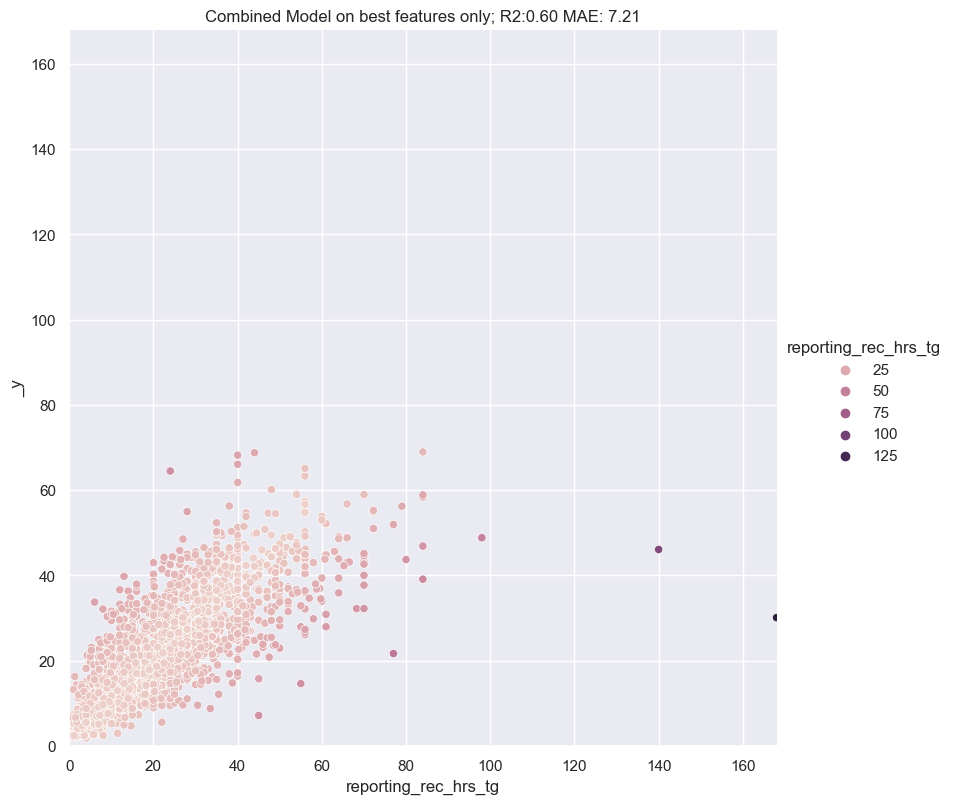

In [118]:
# preds vs rec
ax = sns.relplot(x=y_test, y=combo_preds, height=8, hue=np.abs(y_test - combo_preds))
ax.set(ylim=(0, 168))
ax.set(xlim=(0, 168))
ax.set(title=f'Combined Model on best features only; R2:{combo_est.score(x_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - combo_preds)):.02f}');

In [119]:
# Set lower and upper quantile
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

lower_model = HistGradientBoostingRegressor(loss="quantile",
                                            quantile=LOWER_ALPHA,
                                            **hyper_params
                                           ).fit(x_train, y_train)

upper_model = HistGradientBoostingRegressor(loss="quantile",
                                            quantile=UPPER_ALPHA,
                                            **hyper_params
                                           ).fit(x_train, y_train)

In [120]:
l_preds = lower_model.predict(x_test)
h_preds = upper_model.predict(x_test)

In [121]:
# add in current hrs
x_train = training_df[b_features + ['reporting_current_hrs_ft']]
y_train = training_df[target]

x_test = test_df[b_features + ['reporting_current_hrs_ft']]
y_test = test_df[target]

In [122]:
# Set lower and upper quantile
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

lower_model_ch = HistGradientBoostingRegressor(loss="quantile",
                                            quantile=LOWER_ALPHA,
                                            **hyper_params
                                           ).fit(x_train, y_train)

upper_model_ch = HistGradientBoostingRegressor(loss="quantile",
                                            quantile=UPPER_ALPHA,
                                            **hyper_params
                                           ).fit(x_train, y_train)

In [123]:
l_preds_ch = lower_model_ch.predict(x_test)
h_preds_ch = upper_model_ch.predict(x_test)

In [124]:
out_cols = ['sfere_id', 'patient_id', 'reporting_current_hrs_ft', target]
output_df = test_df[out_cols + b_features].assign(predicted_hrs=combo_preds,
                                                  error=np.abs(combo_preds - y_test),
                                                  lower_bound_preds=l_preds,
                                                  upper_bound_preds=h_preds,
                                                  lower_bound_preds_w_cur_hrs=l_preds_ch,
                                                  upper_bound_preds_w_cur_hrs=h_preds_ch)

In [125]:
err_std_by_payer = output_df.groupby('payer_id_ft').error.std().to_dict()
output_df = output_df.assign(payer_error_std=output_df.apply(lambda x: x.error / err_std_by_payer[x.payer_id_ft], axis=1),
                             in_range=(output_df.reporting_rec_hrs_tg >= output_df.lower_bound_preds) & (output_df.reporting_rec_hrs_tg <= output_df.upper_bound_preds),
                             in_range_w_cur_hrs=(output_df.reporting_rec_hrs_tg >= output_df.lower_bound_preds_w_cur_hrs) & (output_df.reporting_rec_hrs_tg <= output_df.upper_bound_preds_w_cur_hrs),
                            )

In [126]:
output_df.head()

,sfere_id,patient_id,reporting_current_hrs_ft,reporting_rec_hrs_tg,payer_id_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,shopping_ft,medication_management_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_day_time_ft,has_dementia_ft,age_ft,neurocognitive_ddos_ft,predicted_hrs,error,lower_bound_preds,upper_bound_preds,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_error_std,in_range,in_range_w_cur_hrs
12,35771,12551,19.43,19.43,8,1,1,3,3,3,3.0,3,2,2,2.0,2.0,2.0,0.0,1.0,0.0,55,NaN,22.366559,2.936559,8.225735,33.583377,16.066416,19.468984,0.844843,True,True
20,37496,14407,10.69,9.20,8,0,0,3,3,0,3.0,0,1,1,2.0,2.0,1.0,0.0,1.0,0.0,56,0.0,10.490288,1.290288,3.475227,20.362160,6.488731,11.005817,0.371213,True,True
32,36001,12569,7.13,5.17,8,0,0,2,3,0,0.0,2,1,1,0.0,2.0,0.0,0.0,1.0,0.0,62,0.0,10.633985,5.463985,2.632637,20.027901,4.961857,7.224191,1.571978,True,True
36,39093,16312,NaN,5.17,8,0,0,0,2,0,0.0,0,0,1,2.0,2.0,1.0,0.0,1.0,0.0,78,0.0,6.198210,1.028210,2.246350,10.338645,4.654087,47.399976,0.295814,True,True
72,37888,18539,9.77,7.99,8,0,0,2,2,1,2.0,0,1,1,2.0,1.0,1.0,1.0,1.0,1.0,70,0.0,11.308314,3.318314,3.623094,21.642599,6.409231,10.186207,0.954673,True,True


In [129]:
x_train.columns.tolist()

['payer_id_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'housework_ft',
 'transportation_ft',
 'comprehension_ft',
 'alert_oriented_day_time_ft',
 'has_dementia_ft',
 'age_ft',
 'neurocognitive_ddos_ft',
 'reporting_current_hrs_ft']

In [131]:
cols = [
 'sfere_id',
 'patient_id',
 'payer_id_ft',
 'reporting_rec_hrs_tg',
 'reporting_current_hrs_ft',
 'predicted_hrs',
 'error',
 'lower_bound_preds',
 'upper_bound_preds',
 'lower_bound_preds_w_cur_hrs',
 'upper_bound_preds_w_cur_hrs',
 'payer_error_std',
 'in_range',
 'in_range_w_cur_hrs',
 'age_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'meal_prep_ft',
 # 'shopping_ft',
 # 'medication_management_ft',
 'housework_ft',
 'transportation_ft',
 'comprehension_ft',
 'alert_oriented_day_time_ft',
 'has_dementia_ft',
 'neurocognitive_ddos_ft',
]
output_df = output_df[cols]
output_df.head()

,sfere_id,patient_id,payer_id_ft,reporting_rec_hrs_tg,reporting_current_hrs_ft,predicted_hrs,error,lower_bound_preds,upper_bound_preds,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_error_std,in_range,in_range_w_cur_hrs,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_day_time_ft,has_dementia_ft,neurocognitive_ddos_ft
12,35771,12551,8,19.43,19.43,22.366559,2.936559,8.225735,33.583377,16.066416,19.468984,0.844843,True,True,55,1,1,3,3,3,3.0,3,2,2.0,2.0,0.0,1.0,0.0,NaN
20,37496,14407,8,9.20,10.69,10.490288,1.290288,3.475227,20.362160,6.488731,11.005817,0.371213,True,True,56,0,0,3,3,0,3.0,0,1,2.0,1.0,0.0,1.0,0.0,0.0
32,36001,12569,8,5.17,7.13,10.633985,5.463985,2.632637,20.027901,4.961857,7.224191,1.571978,True,True,62,0,0,2,3,0,0.0,2,1,2.0,0.0,0.0,1.0,0.0,0.0
36,39093,16312,8,5.17,NaN,6.198210,1.028210,2.246350,10.338645,4.654087,47.399976,0.295814,True,True,78,0,0,0,2,0,0.0,0,0,2.0,1.0,0.0,1.0,0.0,0.0
72,37888,18539,8,7.99,9.77,11.308314,3.318314,3.623094,21.642599,6.409231,10.186207,0.954673,True,True,70,0,0,2,2,1,2.0,0,1,1.0,1.0,1.0,1.0,1.0,0.0


In [132]:
output_df.describe()

,sfere_id,patient_id,payer_id_ft,reporting_rec_hrs_tg,reporting_current_hrs_ft,predicted_hrs,error,lower_bound_preds,upper_bound_preds,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_error_std,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_day_time_ft,has_dementia_ft,neurocognitive_ddos_ft
count,1938.000000,1938.000000,1938.000000,1938.000000,1850.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1937.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1938.000000,1515.000000,1294.000000,1852.000000,1932.000000,1931.000000,1668.000000
mean,33461.432921,25712.912797,7.234778,21.925567,25.764486,22.035646,7.207387,10.280256,37.497581,16.137688,27.255245,1.092785,72.201754,0.885449,0.883901,1.427761,1.668731,0.415893,1.275026,0.968524,1.132095,1.497030,0.689335,0.185745,0.788302,0.128949,1.115108
std,10554.849805,15650.181058,4.251161,16.236831,18.085829,12.633915,7.341722,7.243371,16.993594,11.572830,18.276183,1.026680,14.618821,1.143898,1.152062,1.149709,1.054363,0.824505,1.144314,1.196942,0.730691,0.641341,0.769243,0.442296,0.408617,0.335230,3.517366
min,13.000000,1.000000,2.000000,0.460000,0.000000,1.822864,0.002880,0.296096,6.944012,0.082710,6.003706,0.000829,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35986.000000,10468.000000,4.000000,9.000000,12.000000,11.858272,2.363597,4.962069,24.116039,6.805480,12.001372,0.376879,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37694.500000,28256.000000,6.000000,18.500000,21.000000,19.752752,5.329219,8.391008,34.742948,13.160298,23.502376,0.846275,74.000000,0.000000,0.000000,2.000000,2.000000,0.000000,2.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,38909.750000,39701.500000,12.000000,31.937500,36.000000,30.319215,9.968948,14.030434,49.962494,24.153965,39.907000,1.503752,82.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,42207.000000,50979.000000,13.000000,168.000000,168.000000,68.969292,137.891405,36.680226,107.606972,51.248193,135.092285,14.835570,105.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,52.000000


In [135]:
output_df[cols].to_csv('../data/ds_all_payer_model_results_20230110.csv', index=False)

In [133]:
output_df.in_range.value_counts() / output_df.shape[0]

True     0.877193
False    0.122807
Name: in_range, dtype: float64

In [134]:
output_df.in_range_w_cur_hrs.value_counts() / output_df.shape[0]

True     0.859133
False    0.140867
Name: in_range_w_cur_hrs, dtype: float64